In [1]:
# Importing relevant modules
# 10/03/2025
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gravitational_force(r1, r2, m1, m2, G=1.0):
    """
    Compute the gravitational force on mass m1 at position r1 
    due to mass m2 at position r2, under Newton's law of gravitation.
    
    Parameters
    ----------
    r1 : ndarray
        Position of mass m1, shape (dim,).
    r2 : ndarray
        Position of mass m2, shape (dim,).
    m1 : float
        Mass of the first body.
    m2 : float
        Mass of the second body.
    G : float
        Gravitational constant (default 1.0 for normalized units).
    
    Returns
    -------
    force : ndarray, shape (dim,)
        The vector gravitational force on m1 by m2.
    """
    r12 = r2 - r1
    dist = np.linalg.norm(r12)
    
    if dist == 0:
        F = np.zeros_like(r12) 

    else:
        F = (G * m1 * m2 / dist**3) * r12
    return F

In [3]:
def total_force(i, positions, masses, G=1.0):
    """
    Calculate the net gravitational force on body i from all other bodies.
    
    Parameters
    ----------
    i : int
        Index of the target body.
    positions : ndarray
        Positions of all bodies, shape (N, dim).
    masses : ndarray
        Masses of all bodies, shape (N,).
    G : float
        Gravitational constant.
    
    Returns
    -------
    F : ndarray, shape (dim,)
        Net force on body i.
    """
    F = np.zeros_like(positions[i])
    for j in range(len(masses)):
        if j != i:
            F += gravitational_force(positions[i], positions[j], masses[i], masses[j], G=G)
    return F

In [4]:
def velocity_verlet_step(positions, velocities, masses, dt, G=1.0):
    """
    Perform one Velocity Verlet integration step for the entire system.
    
    Parameters
    ----------
    positions : ndarray
        Shape (N, dim). Positions of the N bodies.
    velocities : ndarray
        Shape (N, dim). Velocities of the N bodies.
    masses : ndarray
        Shape (N,). Masses of the bodies.
    dt : float
        Time step size.
    G : float
        Gravitational constant.
    
    Returns
    -------
    new_positions, new_velocities : (ndarray, ndarray)
        Updated positions and velocities after one time step.
    """
    N = len(masses)
    dim = positions.shape[1]
    
    # Forces at current step
    forces_now = np.zeros_like(positions)
    for i in range(N):
        forces_now[i] = total_force(i, positions, masses, G=G)    
    # Predict positions at t + dt
    new_positions = positions + dt * velocities + 0.5 * (dt**2) * (forces_now / masses[:, None])
    
    # Forces at t + dt
    forces_next = np.zeros((N, dim))
    for i in range(N):
        forces_next[i] = total_force(i, new_positions, masses, G=G)
    
    # Correct velocities
    new_velocities = velocities + 0.5 * dt * ((forces_now + forces_next) / masses[:, None])
    
    return new_positions, new_velocities

In [5]:
G = 1.0
M_1 = 1.0
M_2 = 3.0e-6
M_3 = 3.7e-8

R_1_2 = 1.0        # "1 AU"
R_2_3 = 0.0025     # ~ distance ratio for Earth-Moon vs. 1 AU

dt = 0.0001
Nsteps = 150000

M_23 = M_2 + M_3
total_mass = M_1 + M_23

# Positions
r_1 = np.array([-R_1_2 * (M_23 / total_mass),  0.0])
r_23 = np.array([+R_1_2 * (M_1 / total_mass),  0.0])

# Solve for circular velocity of the Sun vs. Earth+Moon system
v_1_23 = math.sqrt(G * total_mass / R_1_2)

v_1 = np.array([0.0, +(M_23 / total_mass) * v_1_23])
v_23 = np.array([0.0, -(M_1 / total_mass) * v_1_23])

# Earth-Moon sub-orbit
r_2_offset = np.array([-R_2_3 * (M_3 / M_23),  0.0])
r_3_offset = np.array([+R_2_3 * (M_2 / M_23), 0.0])

r_2 = r_23 + r_2_offset
r_3 = r_23 + r_3_offset

v_2_3 = math.sqrt(G * M_23 / R_2_3)

v_2_sub = np.array([0.0, +(M_3 / M_23) * v_2_3])
v_3_sub = np.array([0.0, -(M_2 / M_23) * v_2_3])

v_2 = v_23 + v_2_sub
v_3 = v_23 + v_3_sub

# Combine all bodies
positions = np.array([r_1, r_2, r_3])
velocities = np.array([v_1, v_2, v_3])
masses = np.array([M_1, M_2, M_3])

# Initialize position and velocity history using NumPy arrays
pos_history = np.zeros((Nsteps, 3, 2))
vel_history = np.zeros((Nsteps, 3, 2))

# Integration loop
for step in range(Nsteps):
    pos_history[step] = positions
    vel_history[step] = velocities
    positions, velocities = velocity_verlet_step(positions, velocities, masses, dt, G=G)

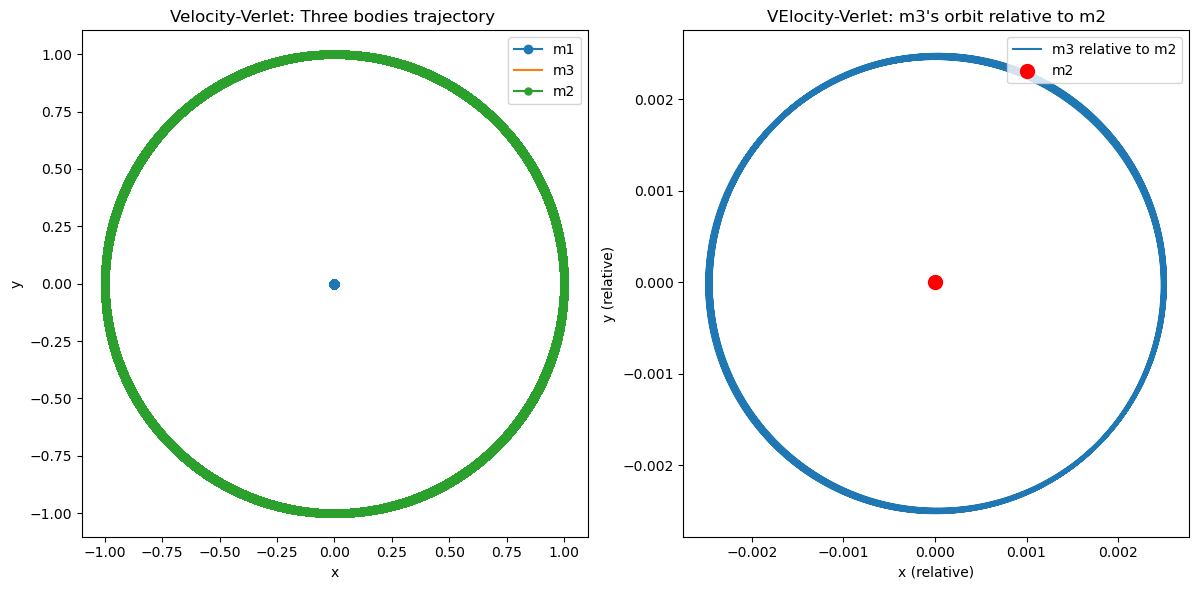

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# First subplot: 1-2-3 system
ax[0].plot(pos_history[:,0,0], pos_history[:,0,1], label="m1", marker='o')
ax[0].plot(pos_history[:,2,0], pos_history[:,2,1], label="m3")
ax[0].plot(pos_history[:,1,0], pos_history[:,1,1], label="m2", marker='o', markersize=5)

ax[0].set_title("Velocity-Verlet: Three bodies trajectory ")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].legend()
ax[0].axis("equal")

# Compute 3's position relative to 2
pos_3_rel_2 = pos_history[:,2,:] - pos_history[:,1,:]

# Second subplot: 3 relative to 2
ax[1].plot(pos_3_rel_2[:,0], pos_3_rel_2[:,1], label="m3 relative to m2")
ax[1].scatter(0, 0, color='red', label="m2", marker='o', s=100) # 2 at origin

ax[1].set_title("VElocity-Verlet: m3's orbit relative to m2")
ax[1].set_xlabel("x (relative)")
ax[1].set_ylabel("y (relative)")
ax[1].legend(loc='upper right')
ax[1].axis("equal")

plt.tight_layout()
plt.savefig(fname='3Body Trajecotory')
plt.show()

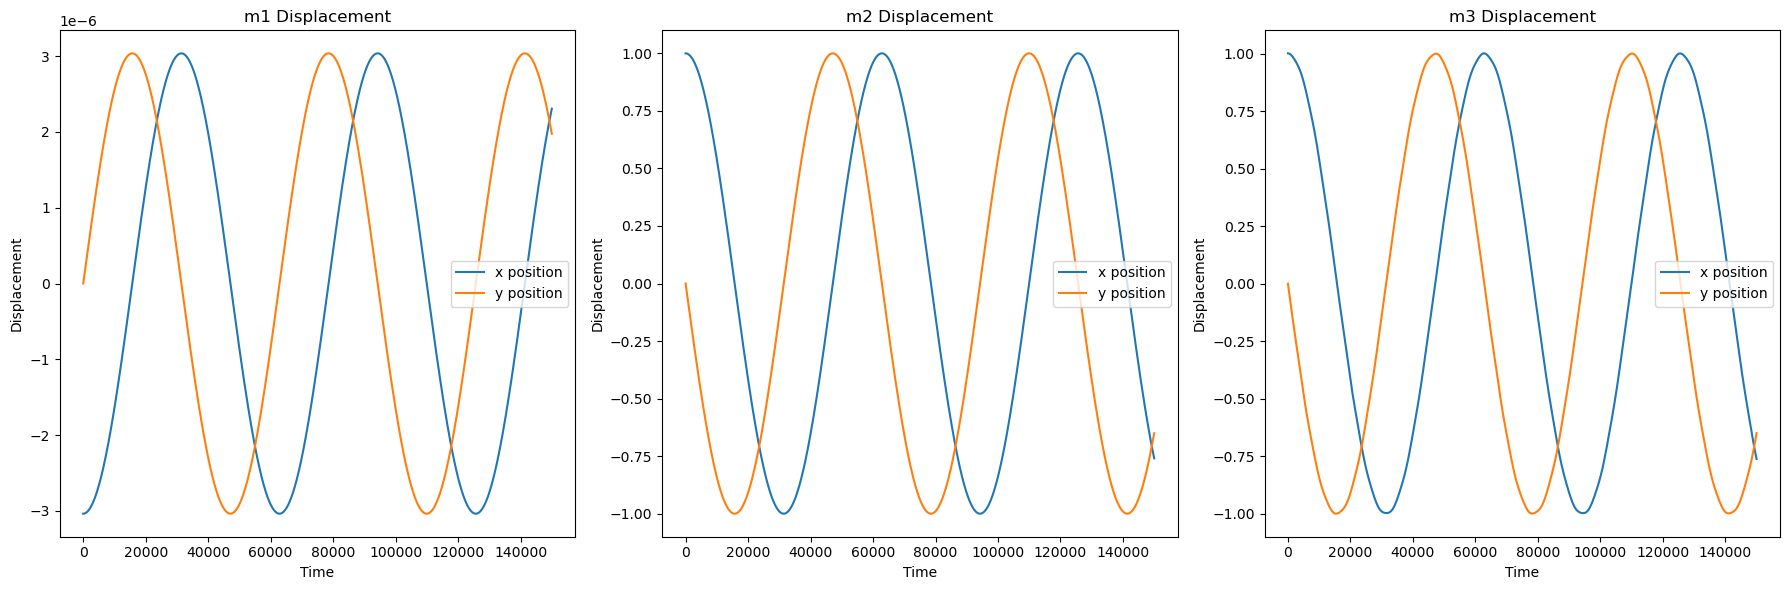

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

# First subplot: m1 trajectory
t = np.arange(pos_history.shape[0])
ax[0].plot(t, pos_history[:,0,0], label="x position")
ax[0].plot(t, pos_history[:,0,1], label="y position")
ax[0].set_title("m1 Displacement")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Displacement")
ax[0].legend()

# Second subplot: m2 trajectory
ax[1].plot(t, pos_history[:,1,0], label="x position")
ax[1].plot(t, pos_history[:,1,1], label="y position")
ax[1].set_title("m2 Displacement")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Displacement")
ax[1].legend()

# Third subplot: m3 trajectory
ax[2].plot(t, pos_history[:,2,0], label="x position")
ax[2].plot(t, pos_history[:,2,1], label="y position")
ax[2].set_title("m3 Displacement")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Displacement")
ax[2].legend()

plt.tight_layout()
plt.savefig(fname='3Body positions')
plt.show()

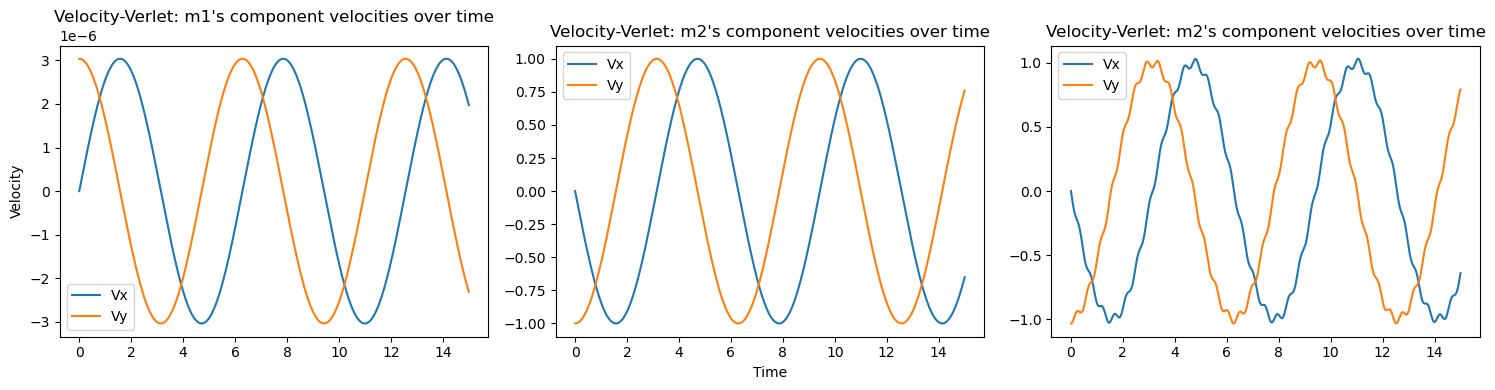

In [8]:
# Assuming pos_history and vel_history are already computed
time = np.arange(Nsteps) * dt  # Time array

# Extract velocity components
v1_x, v1_y = vel_history[:, 0, 0], vel_history[:, 0, 1]
v2_x, v2_y = vel_history[:, 1, 0], vel_history[:, 1, 1]
v3_x, v3_y = vel_history[:, 2, 0], vel_history[:, 2, 1]

# Plot velocities
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sun
axes[0].plot(time, v1_x, label="Vx")
axes[0].plot(time, v1_y, label="Vy")
axes[0].set_title("Velocity-Verlet: m1's component velocities over time")
axes[0].set_ylabel("Velocity")
axes[0].legend()

# Earth
axes[1].plot(time, v2_x, label="Vx")
axes[1].plot(time, v2_y, label="Vy")
axes[1].set_title("Velocity-Verlet: m2's component velocities over time")
axes[1].set_xlabel("Time")
axes[1].legend()

# Moon
axes[2].plot(time, v3_x, label="Vx")
axes[2].plot(time, v3_y, label="Vy")
axes[2].set_title("Velocity-Verlet: m2's component velocities over time")
axes[2].legend()

plt.tight_layout()
plt.savefig(fname='3Body velocities')
plt.show()

In [9]:
masses = np.array([M_1, M_2, M_3])

# Assuming pos_history and velocities are already defined
Nsteps = len(pos_history)

# Arrays to store energies and angular momentum over time
KE_history = []
PE_history = []
L_history = []

for step in range(Nsteps):
    positions = pos_history[step]
    velocities = vel_history[step]  # Assuming a history of velocities exists
    
    # Compute kinetic energy (KE)
    KE = 0.5 * np.sum(masses[:, None] * np.sum(velocities**2, axis=1))
    KE_history.append(KE)
    
    # Compute potential energy (PE)
    PE = 0.0
    for i in range(len(masses)):
        for j in range(i + 1, len(masses)):
            r_ij = np.linalg.norm(positions[i] - positions[j])
            PE -= G * masses[i] * masses[j] / r_ij
    PE_history.append(PE)
    
    # Compute angular momentum (L) (z-component only for 2D motion)
    L = np.sum(masses[:, None] * np.cross(positions, velocities))
    L_history.append(L)

# Convert lists to arrays
KE_history = np.array(KE_history)
PE_history = np.array(PE_history)
TE_history = KE_history + PE_history
L_history = np.array(L_history)

In [10]:
KE, PE, L = np.zeros(Nsteps), np.zeros(Nsteps), np.zeros(Nsteps)
for step in range(Nsteps):
    positions, velocities = pos_history[step], vel_history[step]
    KE[step] = 0.5 * np.sum(masses * np.sum(velocities**2, axis=1))
    for i in range(3):
        for j in range(i + 1, 3):
            PE[step] -= G * masses[i] * masses[j] / np.linalg.norm(positions[i] - positions[j])
    L[step] = np.sum(masses * (positions[:, 0] * velocities[:, 1] - positions[:, 1] * velocities[:, 0]))
E = KE + PE

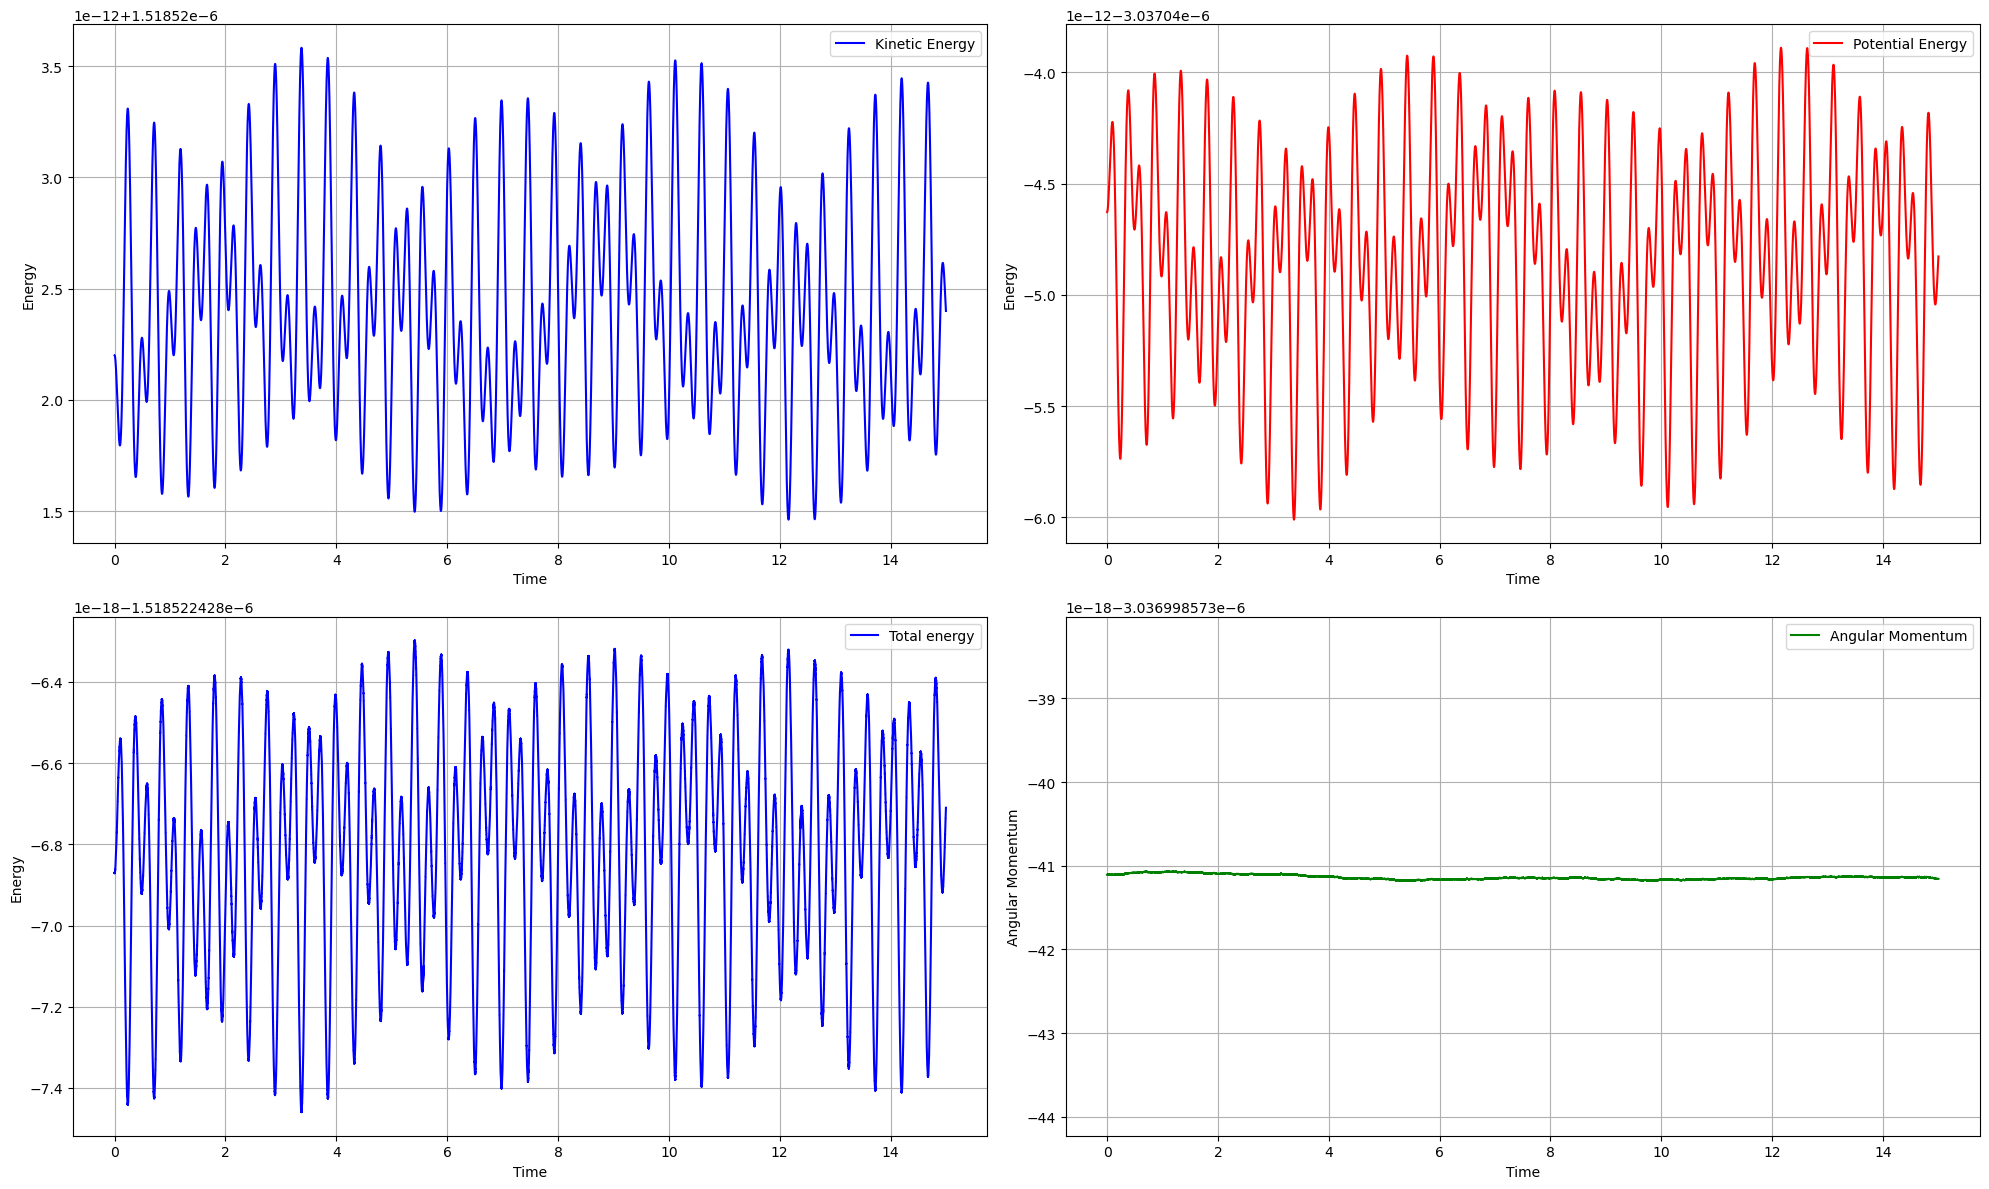

In [11]:
# Plot the results
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

time = np.arange(Nsteps) * dt  # Time array

ax[0, 0].plot(time, KE, label='Kinetic Energy', color='b')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Energy')
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(time, PE, label='Potential Energy', color='r')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Energy')
ax[0, 1].legend()
ax[0, 1].grid()

ax[1, 0].plot(time, E, label='Total energy', color='b')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Energy')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].plot(time, L, label='Angular Momentum', color='g')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Angular Momentum')
ax[1, 1].legend()
ax[1, 1].grid()

plt.tight_layout()
plt.savefig(fname='3Body energies')
plt.show()

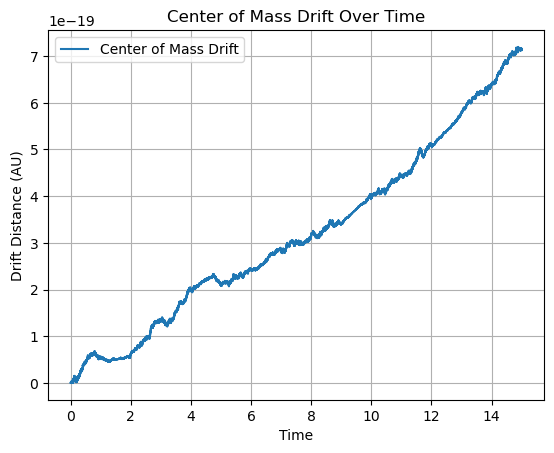

In [12]:
# Compute the Center of Mass at each step
com_x = (masses[0] * pos_history[:, 0, 0] + masses[1] * pos_history[:, 1, 0] + masses[2] * pos_history[:, 2, 0]) / total_mass
com_y = (masses[0] * pos_history[:, 0, 1] + masses[1] * pos_history[:, 1, 1] + masses[2] * pos_history[:, 2, 1]) / total_mass

# Compute displacement from initial CoM
com_drift = np.sqrt((com_x - com_x[0])**2 + (com_y - com_y[0])**2)

plt.figure()
plt.plot(time, com_drift, label="Center of Mass Drift")
plt.xlabel("Time")
plt.ylabel("Drift Distance (AU)")
plt.title("Center of Mass Drift Over Time")
plt.legend()
plt.grid()
plt.savefig(fname='3Body COM drift')
plt.show()

I tried calculating the error by checking the error in c and y positions, but that required me to define the true positions, which proved extremely challending. Hence i use this drift of Centre of Masss method to check for the errors.